In [37]:
# Graph neural network where edge weights are distances between FC matrices

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split2.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

467
155
{'meta': {'AgeInMonths': 129, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '18', 'nback': '18', 'emoid': '18', 'ID': 600110937794}


In [48]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [49]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [50]:
# Calculare pearson matrices

train_p = [np.corrcoef(sub) for sub in train_rest_ts]
test_p = [np.corrcoef(sub) for sub in test_rest_ts]

print('Complete')

Complete


In [51]:
# Create feature vectors (right now just ages)

y_train = []
for subj in train:
    feat = subj['meta']['AgeInMonths']
    y_train.append(feat)
    
y_test = []
for subj in test:
    feat = subj['meta']['AgeInMonths']
    y_test.append(feat)
    
y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_train.shape)
print('Complete')

(467,)
Complete


In [52]:
# Torch pearson matrices

import torch
import torch.nn as nn
import torch.nn.functional as F

train_p_torch = [torch.from_numpy(p).float().cuda() for p in train_p]
test_p_torch = [torch.from_numpy(p).float().cuda() for p in test_p]

print('Complete')

Complete


In [56]:
# CNN

import math

print(train_p_torch[0].shape)
nc = 10
sz1 = math.floor((264-20)/2+1)
sz2 = math.floor((sz1-10)/2+1)
sz3 = math.floor((sz2-8)/2+1)
sz4 = math.floor((sz3-10)/2+1)

class FCCNN(nn.Module):
    def __init__(self):
        super(FCCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,nc,(20,20),2).cuda()
        self.mp1 = nn.MaxPool2d((10,10),2)
        self.conv2 = nn.Conv2d(nc,nc,(8,8),2).cuda()
        self.mp2 = nn.MaxPool2d((10,10),2)
        self.fc1 = nn.Linear(nc*sz4*sz4,200).cuda()
        self.fc2 = nn.Linear(200,1).cuda()
        
    def forward(self, x):
        nb = x.shape[0]
        x = F.relu(self.conv1(x.unsqueeze(1)))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = x.reshape([nb,-1])
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
fccnn = FCCNN()
optimcnn = torch.optim.Adam(fccnn.parameters(), lr=1e-3)

print('Complete')

torch.Size([264, 264])
Complete


In [28]:
print(sz4)

9


In [57]:
# Train CNN

import random

N = len(train_p_torch)
running = 0
nEpoch = 4000
pPeriod = 100
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch).cuda()
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        subj = train_p_torch[idx]
        batch.append(subj)
        truth[i] = y_train[idx]
    batch = torch.stack(batch,dim=0)
    optimcnn.zero_grad()
    pred = fccnn(batch).flatten()
    loss = torch.sum((truth-pred)**2)
    loss.backward()
    running += loss.cpu()
    optimcnn.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=276852.937500
epoch 100 loss=54600.433594
epoch 200 loss=17467.355469
epoch 300 loss=15995.985352
epoch 400 loss=14230.459961
epoch 500 loss=15322.787109
epoch 600 loss=15387.866211
epoch 700 loss=15351.159180
epoch 800 loss=12396.487305
epoch 900 loss=12839.116211
epoch 1000 loss=12734.258789
epoch 1100 loss=12906.115234
epoch 1200 loss=11169.267578
epoch 1300 loss=11491.082031
epoch 1400 loss=10910.708984
epoch 1500 loss=11797.806641
epoch 1600 loss=9262.738281
epoch 1700 loss=9086.724609
epoch 1800 loss=7611.078613
epoch 1900 loss=7737.610840
epoch 2000 loss=6188.984863
epoch 2100 loss=5402.383789
epoch 2200 loss=5767.071289
epoch 2300 loss=4330.177734
epoch 2400 loss=3316.871582
epoch 2500 loss=3198.909668
epoch 2600 loss=3019.926270
epoch 2700 loss=2165.050781


KeyboardInterrupt: 

[[1.         0.95247546]
 [0.95247546 1.        ]]
1.2994412800768382
1.060023191398931


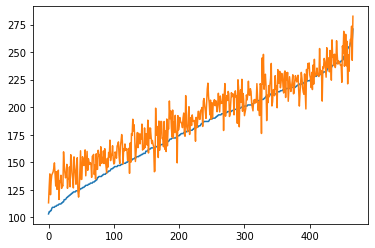

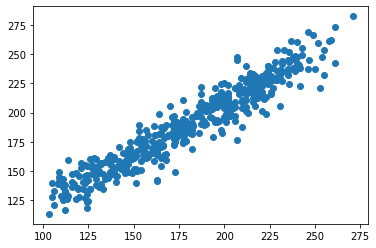

In [59]:
import matplotlib.pyplot as plt

y = y_train
X = []

for subj in train_p_torch:
    X.append(subj)
    
X = torch.stack(X, dim=0)
yPred = fccnn(X).flatten().cpu().detach().numpy()

# yPred = Xtest@w

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()